In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.aformer_TF_gc_separated as aformer
#import src.aformer_TF as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers
import src.utils as utils

import training_utils_aformer_TF_genecentered_separated as training_utils


from scipy import stats



In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-21')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 8
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

In [3]:
with strategy.scope():

    train_steps=50#3200#5165 #320
    warmup_steps=10
    val_steps_h=10#3200#757 ### 5562
    val_steps_m=14
    num_epochs=5
    lr_base=0.001
    warmup_lr=1.0e-06

    data_it_tr_list = []
    data_it_val_list = []

    ### create dataset iterators
    heads_dict = {}
    orgs = ["hg","mm"]
    for k, org in enumerate(orgs):
        heads_dict[org] = int(k)
    data_dict_tr,data_dict_val,val_ho_it = training_utils.return_distributed_iterators(heads_dict,
                                                                             "gs://picard-testing-176520/16k_genecentered_blacklist0.50_atacnormalized/preprocessed",
                                                                             "gs://picard-testing-176520/16k_genecentered_blacklist0.50_atacnormalized/val_holdout/val",
                                                                              GLOBAL_BATCH_SIZE,
                                                                              16384,
                                                                              300,
                                                                              "logTPM",
                                                                              16,
                                                                              num_epochs,
                                                                              strategy,
                                                                              options)

In [4]:
with strategy.scope():
    model = aformer.aformer(kernel_transformation="relu_kernel_transformation",
                                dropout_rate=0.25,
                                input_length=16384,
                                num_heads=4,
                                numerical_stabilizer=0.0000001,
                                nb_random_features=256,
                                hidden_size=256,
                                d_model=256,
                                norm=True,
                                dim=64,
                                max_seq_length = 2048,
                                rel_pos_bins=2048,
                                widening = 2, ## ratio between first and second dense layer units in transformer block
                                conv_filter_size_1_seq=15,
                                conv_filter_size_2_seq=5,
                                conv_filter_size_1_atac=15,
                                conv_filter_size_2_atac=5,
                                positional_dropout_rate=0.1,
                                transformer_depth=2,
                                momentum=0.90,
                                channels_list=[96,96,112,112,128,128], 
                                kernel_regularizer=0.0000001,
                                bottleneck_units=64,
                            bottleneck_units_tf=64,
                                use_mask_pos=False,
                                use_rot_emb=True,
                                heads_dict=heads_dict)
    

In [5]:
with strategy.scope():
    scheduler= tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=5.0e-04,
        decay_steps=250, alpha=(5.0e-08 / 5.0e-04))
    scheduler=WarmUp(initial_learning_rate=5.0e-04,
                                 warmup_steps=50,
                                 decay_schedule_fn=scheduler)


    optimizer = tfa.optimizers.AdamW(learning_rate=scheduler,
                                     beta_1=0.9,
                                     beta_2=0.999,
                                     weight_decay=0.01)

    optimizer=tfa.optimizers.Lookahead(optimizer,
                                       sync_period=6,
                                       slow_step_size=0.5)
    

In [6]:
with strategy.scope():
    metric_dict = {}
    train_step, val_step, val_ho_step, metric_dict = training_utils.return_train_val_functions_hg(model,
                                                                                 optimizer,
                                                                                 strategy,
                                                                                 metric_dict, 
                                                                                 train_steps,
                                                                                 val_steps_h,
                                                                                 val_steps_m,
                                                                                 GLOBAL_BATCH_SIZE,
                                                                                 0.2,
                                                                                 True,
                                                                                 freq_limit=5000,
                                                                                 fourier_loss_scale=1.0,
                                                                                 use_tf_acc=False) # last is uncropped length


In [7]:
%matplotlib inline

hg_train_loss: 0.5565787
hg_lr: [1.00000007e-05 2.00000013e-05 3.00000029e-05 4.00000026e-05
 5.00000024e-05 6.00000058e-05 7.00000019e-05 8.00000053e-05
 9.00000086e-05 1.00000005e-04 1.10000008e-04 1.20000012e-04
 1.30000015e-04 1.40000004e-04 1.50000007e-04 1.60000011e-04
 1.70000014e-04 1.80000017e-04 1.90000006e-04 2.00000009e-04
 2.10000013e-04 2.20000016e-04 2.30000020e-04 2.40000023e-04
 2.50000012e-04 2.60000030e-04 2.70000019e-04 2.80000007e-04
 2.90000025e-04 3.00000014e-04 3.10000032e-04 3.20000021e-04
 3.30000010e-04 3.40000028e-04 3.50000017e-04 3.60000035e-04
 3.70000023e-04 3.80000012e-04 3.90000030e-04 4.00000019e-04
 4.10000037e-04 4.20000026e-04 4.30000015e-04 4.40000033e-04
 4.50000021e-04 4.60000039e-04 4.70000028e-04 4.80000046e-04
 4.90000006e-04 5.00000024e-04]
hg_it: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
hg_val_loss: 0.377562
hg_val_pearson: 0.257

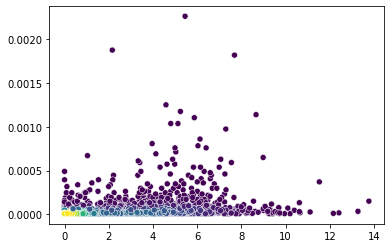

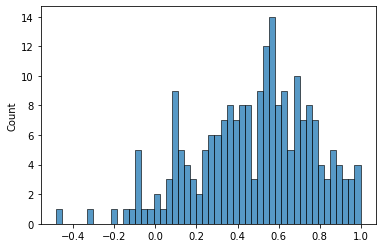

median_cell_crossgenes: 0.5233255490741637


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


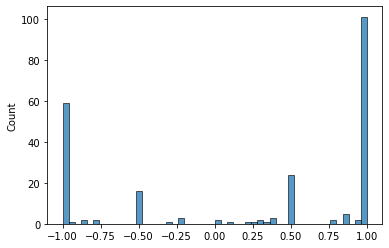

median_gene_crossdataset: 0.5


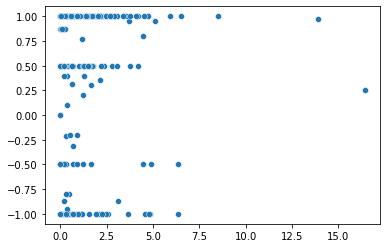

completed epoch 1
duration(mins): 4.672762723763784
patience counter at: 0
hg_train_loss: 0.49132207
hg_lr: [0.00049998 0.00049992 0.00049982 0.00049968 0.00049951 0.00049929
 0.00049903 0.00049874 0.0004984  0.00049803 0.00049762 0.00049716
 0.00049667 0.00049614 0.00049557 0.00049496 0.00049432 0.00049363
 0.00049291 0.00049215 0.00049135 0.00049051 0.00048963 0.00048872
 0.00048777 0.00048678 0.00048575 0.00048469 0.00048358 0.00048245
 0.00048127 0.00048006 0.00047881 0.00047753 0.00047621 0.00047485
 0.00047346 0.00047204 0.00047058 0.00046908 0.00046755 0.00046598
 0.00046439 0.00046275 0.00046109 0.00045939 0.00045765 0.00045589
 0.00045409 0.00045226]
hg_it: [ 51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100]
hg_val_loss: 0.38440874
hg_val_pearson: 0.3144336
hg_val_R2: [-0.99338126]
hg_val_pearson_ho: 0.26828822
hg_val_R2_ho: [-

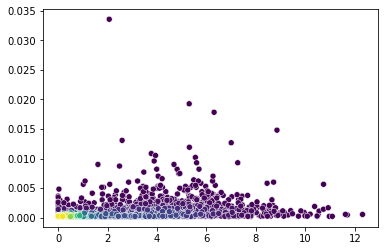

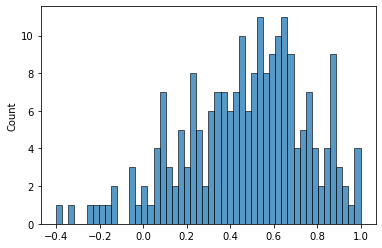

median_cell_crossgenes: 0.5129509618824175


/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


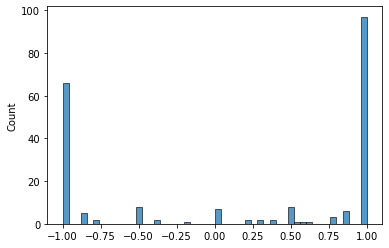

median_gene_crossdataset: 0.616227766016838


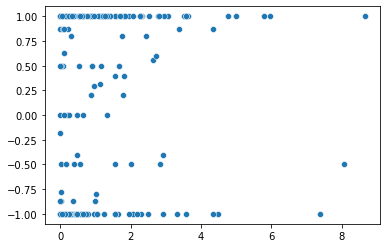

completed epoch 2
duration(mins): 2.6111577987670898
patience counter at: 0
hg_train_loss: 0.50634205
hg_lr: [0.0004504  0.0004485  0.00044658 0.00044462 0.00044263 0.00044062
 0.00043857 0.00043649 0.00043438 0.00043225 0.00043008 0.00042789
 0.00042567 0.00042342 0.00042114 0.00041884 0.00041651 0.00041416
 0.00041177 0.00040937 0.00040693 0.00040447 0.00040199 0.00039949
 0.00039696 0.0003944  0.00039183 0.00038923 0.00038661 0.00038397
 0.00038131 0.00037862 0.00037592 0.00037319 0.00037045 0.00036769
 0.00036491 0.00036211 0.00035929 0.00035646 0.00035361 0.00035074
 0.00034786 0.00034496 0.00034205 0.00033912 0.00033618 0.00033322
 0.00033025 0.00032727]
hg_it: [101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150]
hg_val_loss: 0.38091412
hg_val_pearson: 0.3673268
hg_val_R2: [-0.91589427]
hg_val_pearson_ho: 0.33367622
hg_val_R2_ho: [

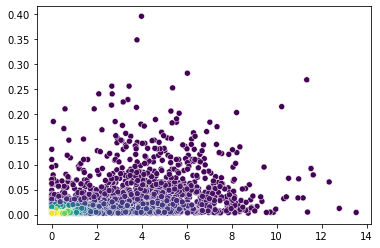

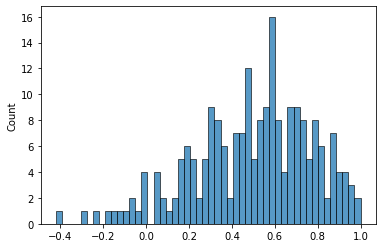

median_cell_crossgenes: 0.5341519434109963


/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3724: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


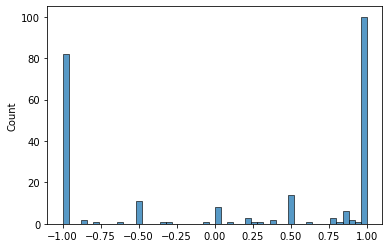

median_gene_crossdataset: 0.5


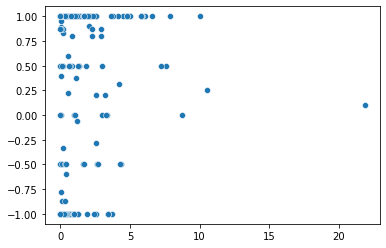

completed epoch 3
duration(mins): 2.6105177561442057
patience counter at: 0


In [ ]:
from scipy.stats.stats import pearsonr  
with strategy.scope():
    def sum_log(x):
        return np.log10(1.0 + np.nansum(x))
    
    global_step = 0
    val_losses = []
    val_pearsons = []
    val_R2 = []
    patience_counter = 0
    stop_criteria = False
    best_epoch = 0

    for epoch_i in range(1, 15):
        start = time.time()
        #if epoch_i > 2 : 
        lr, it = train_step(data_dict_tr['hg'])

                   #data_dict_tr['mm'],
                   #data_dict_tr['rm'])
        print('hg_train_loss: ' + str(metric_dict['hg_tr'].result().numpy()))
        
        print('hg_lr: ' + str(lr.numpy()))
        print('hg_it: ' + str(it.numpy()))
        
        val_step(data_dict_val['hg'])
        val_ho_step(val_ho_it)

        val_losses.append(metric_dict['hg_val'].result().numpy())
        print('hg_val_loss: ' + str(metric_dict['hg_val'].result().numpy()))
        print('hg_val_pearson: ' + str(metric_dict['hg_corr_stats'].result()['pearsonR'].numpy()))
        print('hg_val_R2: ' + str(metric_dict['hg_corr_stats'].result()['R2'].numpy()))
        
        print('hg_val_pearson_ho: ' + str(metric_dict['hg_corr_stats_ho'].result()['pearsonR'].numpy()))
        print('hg_val_R2_ho: ' + str(metric_dict['hg_corr_stats_ho'].result()['R2'].numpy()))
        
        #print('hg_val_pearson_gene: ' + str(metric_dict['hg_corr_stats'].result()['feature_level_pearsonR'].numpy()))
        #print('hg_val_R2_gene: ' + str(metric_dict['hg_corr_stats'].result()['feature_level_R2'].numpy()))
        
        y_trues = metric_dict['hg_corr_stats'].result()['y_trues'].numpy()
        y_preds = metric_dict['hg_corr_stats'].result()['y_preds'].numpy()
        cell_types = metric_dict['hg_corr_stats'].result()['cell_types'].numpy()
        gene_map = metric_dict['hg_corr_stats'].result()['gene_map'].numpy()

        unique_preds = {}
        unique_trues = {}
        for k,x in enumerate(gene_map):
            unique_preds[(cell_types[k],x)] = y_preds[k]
            unique_trues[(cell_types[k],x)] = y_trues[k]
        
        unique_preds = dict(sorted(unique_preds.items()))
        unique_trues = dict(sorted(unique_trues.items()))
        
        
        print('overall gene pearsonsR:', pearsonr(y_trues,
                                                    y_preds)[0])
        
        print('overall gene spearmanR:', spearmanr(y_trues,
                                                    y_preds)[0])
        data = np.vstack([y_trues,y_preds])
        kernel = stats.gaussian_kde(data)(data)
        sns.scatterplot(
            x=y_trues,
            y=y_preds,
            c=kernel,
            cmap="viridis")
        plt.show()
        
        
        ### now compute correlations across cell types
        across_cells_preds = {}
        across_cells_trues = {}
        
        for k,v in unique_preds.items():
            cell_t,gene_name = k
            if cell_t not in across_cells_preds.keys():
                across_cells_preds[cell_t] = []
                across_cells_trues[cell_t] = []
            else:
                across_cells_preds[cell_t].append(v)
                across_cells_trues[cell_t].append(unique_trues[k])
        cell_specific_corrs = []
        for k,v in across_cells_preds.items():
            trues = []
            preds = []
            for idx,x in enumerate(v):
                preds.append(x)
                trues.append(across_cells_trues[k][idx])
            try: 
                cell_specific_corrs.append(pearsonr(trues, 
                                                    preds)[0])
            except np.linalg.LinAlgError:
                continue
            except ValueError:
                continue
                
        sns.histplot(x=np.asarray(cell_specific_corrs), bins=50)
        plt.show()
        print('median_cell_crossgenes:', np.nanmedian(cell_specific_corrs))
                
            
        ### now compute correlations across genes
        across_genes_preds = {}
        across_genes_trues = {}
        
        for k,v in unique_preds.items():
            cell_t,gene_name = k
            if gene_name not in across_genes_preds.keys():
                across_genes_preds[gene_name] = []
                across_genes_trues[gene_name] = []
            else:
                across_genes_preds[gene_name].append(v)
                across_genes_trues[gene_name].append(unique_trues[k])
        genes_specific_corrs = []
        genes_specific_vars = []
        for k,v in across_genes_preds.items():
            trues = []
            preds = []
            for idx, x in enumerate(v):
                #if len(x) > 0:
                preds.append(x)
                trues.append(across_genes_trues[k][idx])
            try: 
                genes_specific_corrs.append(spearmanr(trues, 
                                                     preds)[0])
                genes_specific_vars.append(np.var(trues))
            except np.linalg.LinAlgError:
                continue
            except ValueError:
                continue
                
        sns.histplot(x=np.asarray(genes_specific_corrs), bins=50)
        plt.show()
        print('median_gene_crossdataset:', np.nanmedian(genes_specific_corrs))
            
        sns.scatterplot(
            x=genes_specific_vars,
            y=genes_specific_corrs)
        plt.show()

        #print('mm_train_loss: ' + str(metric_dict['mm_tr'].result().numpy()))

        #print('mm_val_loss: ' + str(metric_dict['mm_val'].result().numpy()))
        #print('mm_val_pearson: ' + str(metric_dict['mm_corr_stats'].result()['pearsonR'].numpy()))
        #print('mm_val_R2: ' + str(metric_dict['mm_corr_stats'].result()['R2'].numpy()))
        
        end = time.time()
        duration = (end - start) / 60.
        print('completed epoch ' + str(epoch_i))
        print('duration(mins): ' + str(duration))
        print('patience counter at: ' + str(patience_counter))

        for key, item in metric_dict.items():
            item.reset_state()

In [ ]:
optimizer.lr(optimizer.iterations)

In [15]:
strategy.reduce("SUM",
                optimizer.iterations, axis=None)

<tf.Tensor: shape=(), dtype=int64, numpy=32>

In [7]:
next(val_ho_it)

{'inputs': PerReplica:{
   0: <tf.Tensor: shape=(8, 16384, 5), dtype=float32, numpy=
 array([[[0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         ...,
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]],
 
        [[0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         ...,
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.]],
 
        [[0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         ...,
         [0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0.],
         [0., 1., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 1.],
         ...,
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 0.]],
 
        [[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 